In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp
import warnings
warnings.filterwarnings("ignore")

In [2]:
dows_df = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
dows_tickers = dows_df.Symbol.tolist()
dows_tickers.sort()
assert len(dows_tickers) == 30
SP500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
SP500_tickers = SP500_df.Symbol.tolist()
SP500_tickers.remove('BF.B')  # delisted
SP500_tickers.remove('BRK.B')  # delisted
SP500_tickers.sort()

In [3]:
def download_data_and_calc_returns(tickers, period='5y', interval='1d', prepost=False):
    data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
    data = data.loc[:,('Adj Close', slice(None))]  # get adjusted close only
    data.columns = tickers
    data = data[tickers].pct_change().dropna()
    return data

dows_returns = download_data_and_calc_returns(dows_tickers)

[*********************100%***********************]  30 of 30 completed


In [4]:
dows_returns.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-21,0.036830,0.004029,0.009479,-0.009198,0.007894,0.021038,0.012768,0.009383,-0.012092,-0.016466,...,0.010599,0.022975,0.015227,0.007570,0.023148,0.006068,0.013334,0.010751,0.012900,0.004258
2019-03-22,-0.020708,-0.027047,-0.021105,-0.028253,-0.032000,-0.032644,-0.022247,-0.022009,-0.003957,-0.007758,...,-0.007957,-0.026368,-0.066129,-0.008098,0.003944,-0.019562,-0.017523,0.025219,-0.018711,-0.007874
2019-03-25,-0.012091,-0.000589,-0.003837,0.022890,0.012407,-0.003839,-0.000190,-0.001625,-0.004066,0.011317,...,0.000729,0.005211,0.001703,0.002951,0.000371,-0.000931,-0.000261,0.005355,-0.011537,-0.001119
2019-03-26,-0.010331,0.009004,0.004219,-0.000216,0.003501,-0.009199,0.009482,0.010090,0.021802,-0.006104,...,0.006922,0.002125,0.012753,0.010396,0.000222,-0.014056,0.014834,0.009154,0.003728,0.001528
2019-03-27,0.008994,-0.010358,-0.004749,0.010341,-0.004854,-0.026851,-0.001691,-0.010795,0.001271,0.025589,...,-0.007598,-0.009669,-0.003478,-0.001165,0.010150,-0.006903,-0.006955,0.004123,0.005007,-0.011290


In [5]:
port = rp.Portfolio(returns=dows_returns, lowerret=(pow(1.5, 0.2) - 1)/252)  # daily return NOT annual
port.assets_stats()
risk_measure = 'SLPM'
objective = 'MinRisk'
risk_free_rate = 0.04
allocations = port.optimization(rm=risk_measure, obj=objective, rf=risk_free_rate)

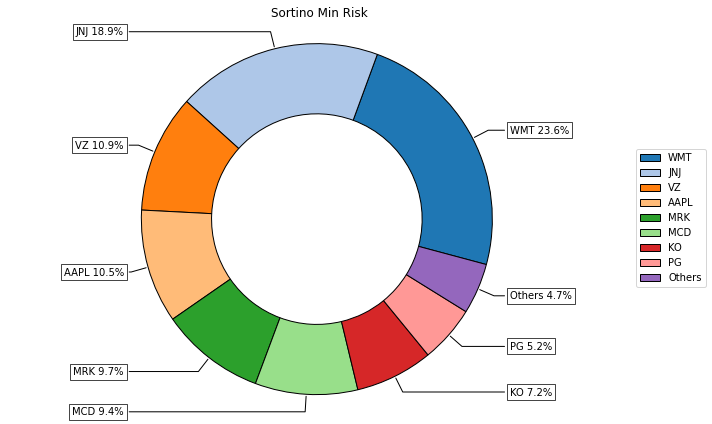

In [6]:
ax = rp.plot_pie(w=allocations, title='Sortino Min Risk', others=0.05, nrow=len(port.assetslist), cmap = "tab20", height=6, width=10, ax=None)

In [7]:
frontier = port.efficient_frontier(rm=risk_measure, points=100, rf=risk_free_rate)
display(frontier.T.head())

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,0.104795,1.995706e-02,1.139897e-10,3.591364e-11,0.015978,1.164066e-10,7.992092e-11,4.141677e-10,1.833630e-10,1.018611e-10,...,0.096564,3.837242e-10,2.121445e-10,0.052466,5.699922e-10,0.010762,1.359311e-10,1.086671e-01,8.022515e-11,0.235662
1,0.152464,9.202995e-03,1.823642e-11,5.098244e-12,0.020420,1.328866e-11,1.086716e-11,8.986436e-11,2.125057e-11,1.617067e-11,...,0.097036,5.066280e-11,2.374134e-11,0.076446,1.085394e-10,0.049094,1.853504e-11,1.381006e-03,1.088318e-11,0.242166
2,0.189170,1.204514e-10,1.531620e-12,3.895887e-13,0.016165,9.499333e-13,8.240110e-13,8.400438e-12,1.503099e-12,1.319257e-12,...,0.087651,4.061672e-12,1.689457e-12,0.079080,8.594446e-12,0.071441,1.414797e-12,7.663478e-12,8.103296e-13,0.235318
3,0.215098,8.444763e-09,4.404447e-10,1.022789e-10,0.012643,2.449126e-10,2.195608e-10,2.647039e-09,3.877292e-10,3.699717e-10,...,0.078894,1.124699e-09,4.391468e-10,0.079972,2.361072e-09,0.086932,3.809103e-10,1.291108e-09,2.131419e-10,0.229770
4,0.236179,2.000921e-09,1.642598e-10,3.656354e-11,0.009780,8.509644e-11,7.795249e-11,1.063408e-09,1.343386e-10,1.355341e-10,...,0.071774,4.076985e-10,1.528065e-10,0.080697,8.511144e-10,0.099528,1.356694e-10,3.662597e-10,7.508681e-11,0.225258


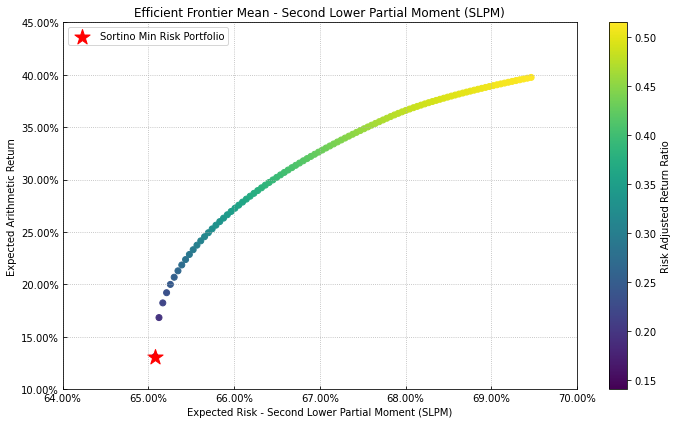

In [8]:
# Plotting the efficient frontier
label = 'Sortino Min Risk Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=risk_measure, alpha=0.05, cmap='viridis', rf=risk_free_rate, w=allocations, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot:title={'center':'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot:title={'center':'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot:title={'center':'Portfolio Composition'}>,
       <AxesSubplot:title={'center':'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot:title={'center':'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot:title={'center':'Historical Uncompounded Drawdown'}>],
      dtype=object)

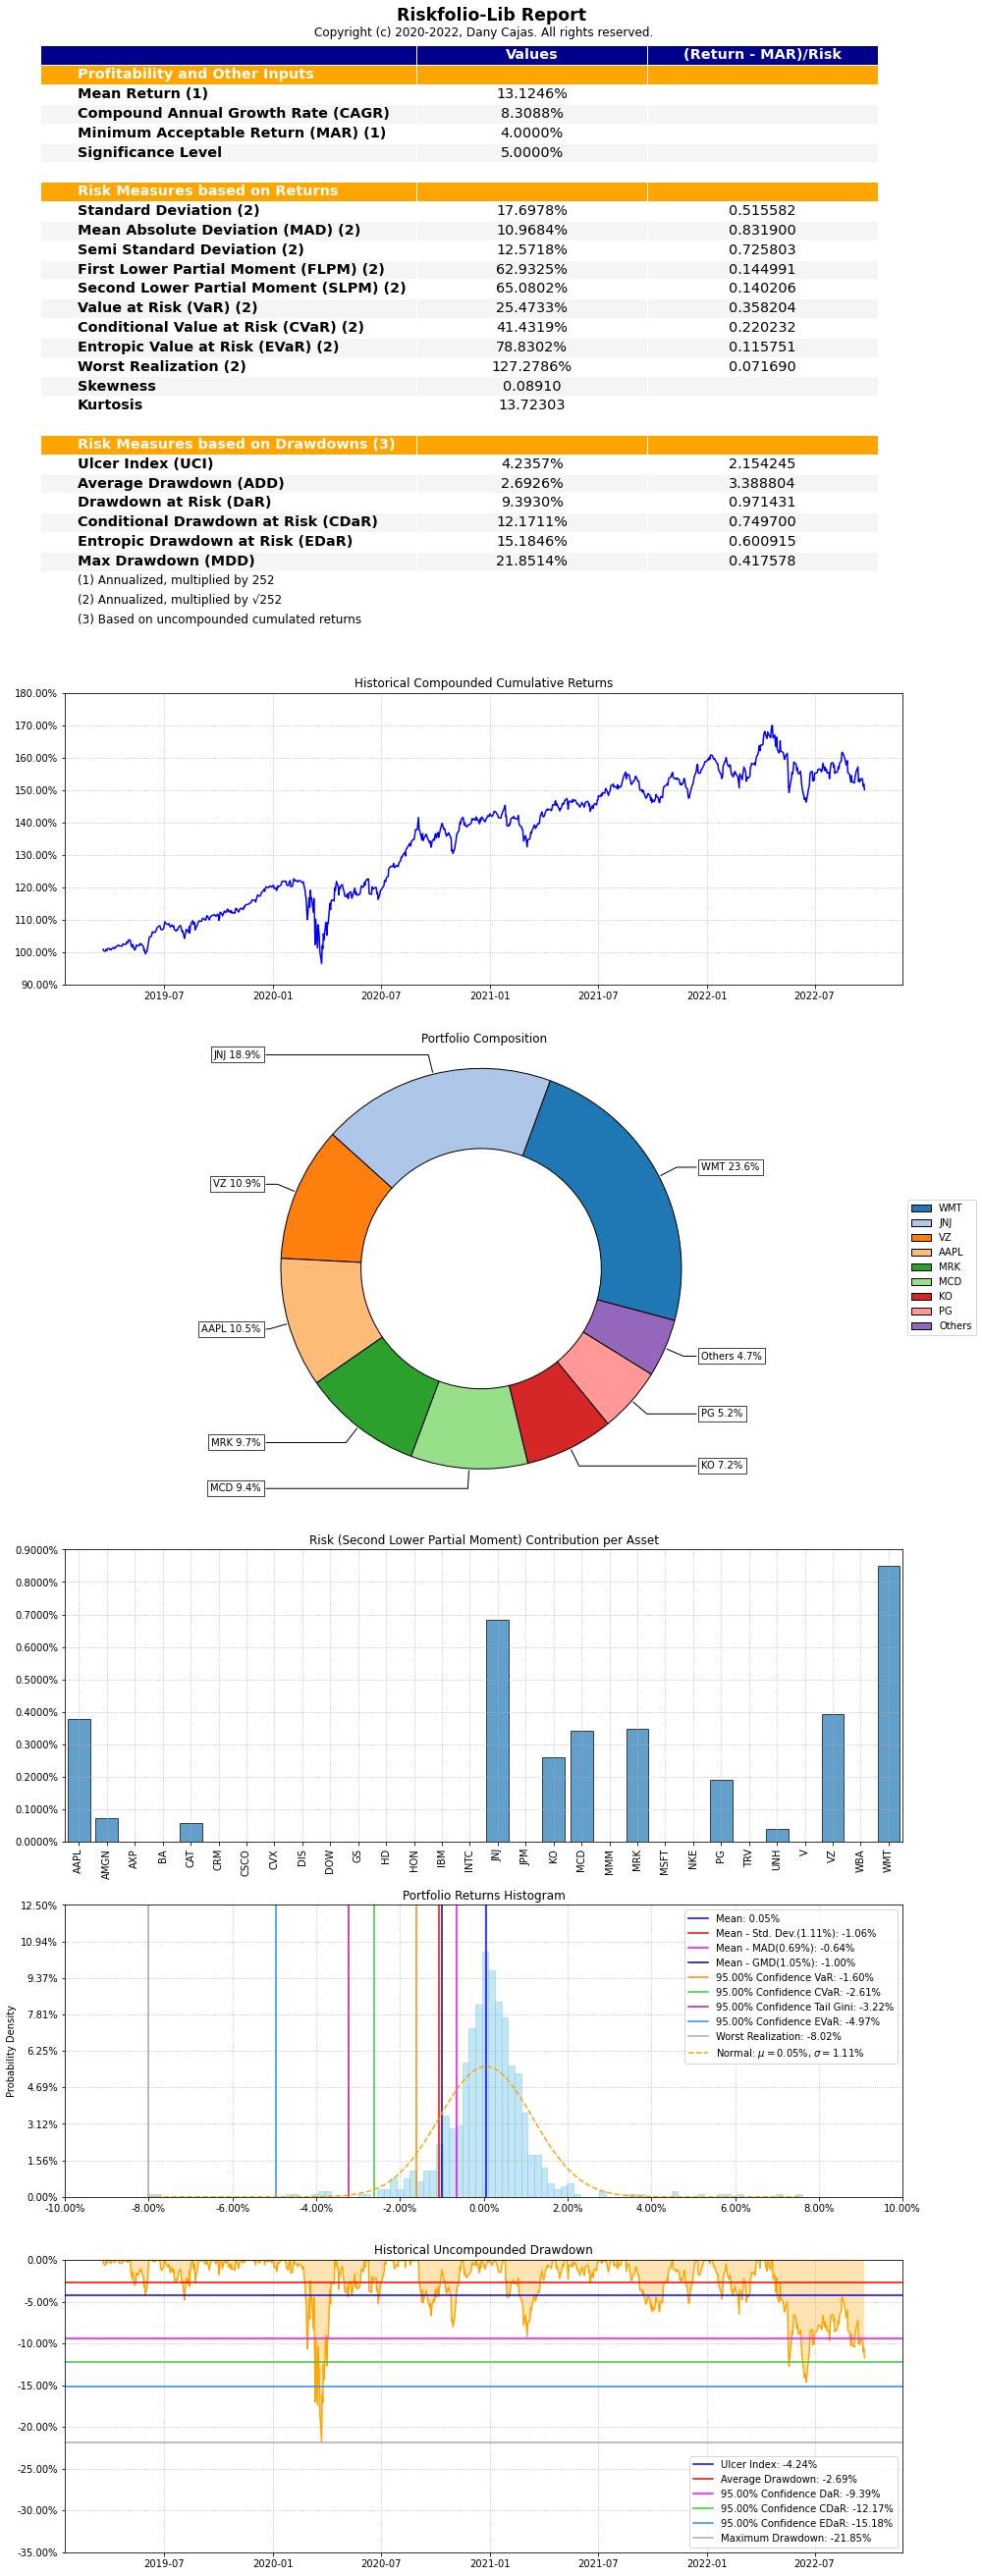

In [9]:
rp.Reports.excel_report(returns, allocations, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='dows_1y_report')
rp.Reports.jupyter_report(returns, allocations, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.05, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)

In [10]:

sp500_returns = download_data_and_calc_returns(SP500_tickers)
sp500_returns.head()

[*********************100%***********************]  501 of 501 completed


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-20,-0.006765,-0.031773,-0.021379,-0.010347,-0.016123,0.003701,0.002417,-0.010631,-0.003055,-0.011092,...,-0.022008,0.000881,0.002189,0.005470,-0.018339,-0.007068,-0.001866,-0.022783,-0.029318,0.006880
2022-01-21,-0.014124,-0.027446,-0.013866,-0.012765,-0.007893,-0.010235,0.006012,0.008981,-0.020602,-0.021415,...,-0.016647,0.000587,-0.015013,-0.007128,0.005351,0.005015,-0.004064,-0.014439,-0.038611,-0.008071
2022-01-24,0.004436,0.006749,0.029449,-0.004864,0.001364,0.000228,0.024198,-0.015974,0.010041,0.039507,...,-0.009924,-0.011580,0.008591,0.017948,0.004669,0.016903,0.009058,-0.007325,0.016518,-0.001298
2022-01-25,-0.025702,0.003047,-0.011297,-0.011385,0.007037,-0.003725,-0.048407,-0.004442,-0.011947,-0.032598,...,0.019575,0.006674,0.029400,-0.021529,-0.034576,-0.033956,-0.021836,-0.033757,0.059105,-0.024092
2022-01-26,-0.007877,-0.013366,-0.021983,-0.000563,0.008566,-0.003891,0.001011,-0.025959,-0.015107,-0.003799,...,-0.003817,-0.003830,-0.010143,-0.003983,-0.012805,-0.015649,-0.003803,0.003587,0.010830,-0.027708


You must convert self.cov to a positive definite matrix


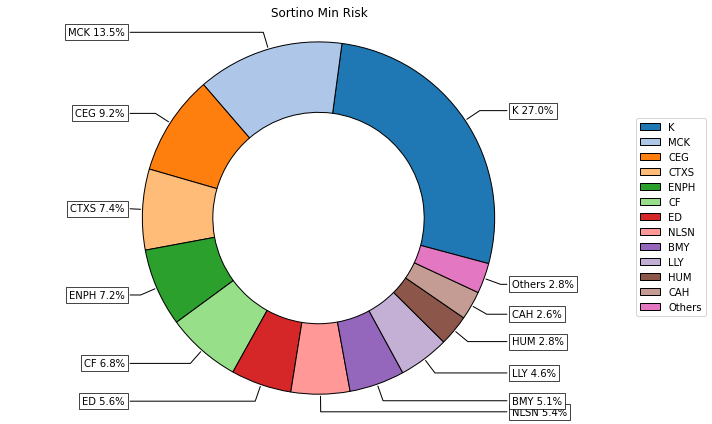

In [11]:
port = rp.Portfolio(returns=sp500_returns, lowerret=(pow(1.5, 0.2)-1)/252)
port.assets_stats()
risk_measure = 'SLPM'
objective = 'MinRisk'
allocations = port.optimization(rm=risk_measure, obj=objective, rf=risk_free_rate)
ax = rp.plot_pie(w=allocations, title='Sortino Min Risk', others=0.05, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

In [12]:
frontier = port.efficient_frontier(rm=risk_measure, points=100, rf=risk_free_rate)
display(frontier.T.head())

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,5.744418e-12,3.340083e-12,3.897453e-12,5.015305e-12,1.457387e-09,9.390599e-12,3.927715e-12,5.177001e-12,3.898274e-12,2.695237e-12,...,3.669749e-12,2.367268e-11,2.846294e-11,3.566571e-12,4.845573e-12,8.841102e-12,7.001084e-12,2.437410e-12,5.859923e-12,4.513071e-12
1,2.466393e-12,1.508536e-12,1.682568e-12,2.271620e-12,2.957690e-11,4.051625e-12,1.761310e-12,2.209997e-12,1.681079e-12,1.089988e-12,...,1.571357e-12,8.666975e-12,8.872684e-12,1.477176e-12,2.191220e-12,3.482210e-12,2.899746e-12,1.019235e-12,2.510839e-12,1.922178e-12
2,2.202742e-11,1.359277e-11,1.526439e-11,2.062745e-11,1.759058e-10,3.661618e-11,1.589071e-11,1.970025e-11,1.524984e-11,1.002255e-11,...,1.393158e-11,7.050948e-11,7.174774e-11,1.318043e-11,1.980808e-11,2.974570e-11,2.507986e-11,9.401740e-12,2.211686e-11,1.724488e-11
3,1.630098e-11,1.008396e-11,1.136194e-11,1.539605e-11,1.099233e-10,2.733529e-11,1.184080e-11,1.455706e-11,1.134522e-11,7.419294e-12,...,1.027521e-11,4.985440e-11,5.044606e-11,9.718007e-12,1.477260e-11,2.152686e-11,1.824095e-11,6.985875e-12,1.626757e-11,1.279038e-11
4,1.098764e-11,6.822352e-12,7.690231e-12,1.043253e-11,6.745820e-11,1.848921e-11,8.023223e-12,9.802502e-12,7.677601e-12,5.017573e-12,...,6.926844e-12,3.268794e-11,3.294000e-11,6.542588e-12,1.000882e-11,1.431105e-11,1.216462e-11,4.737971e-12,1.092825e-11,8.635136e-12


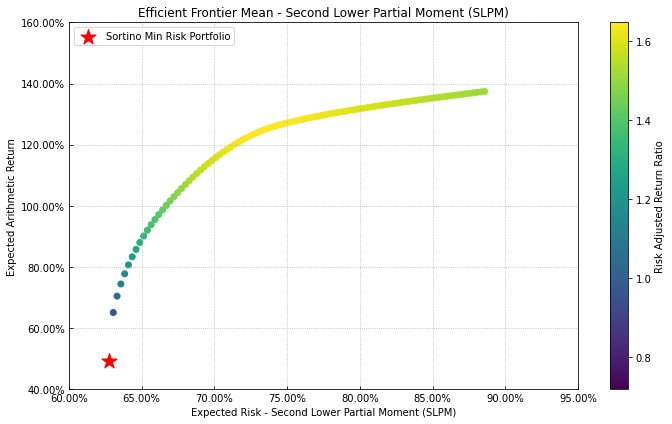

In [13]:
# Plotting the efficient frontier
label = 'Sortino Min Risk Portfolio'  # Title of point
mu = port.mu  # Expected returns
cov = port.cov  # Covariance matrix
returns = port.returns  # Returns of the assets
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=risk_measure, rf=risk_free_rate, alpha=0.05, cmap='viridis', w=allocations, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

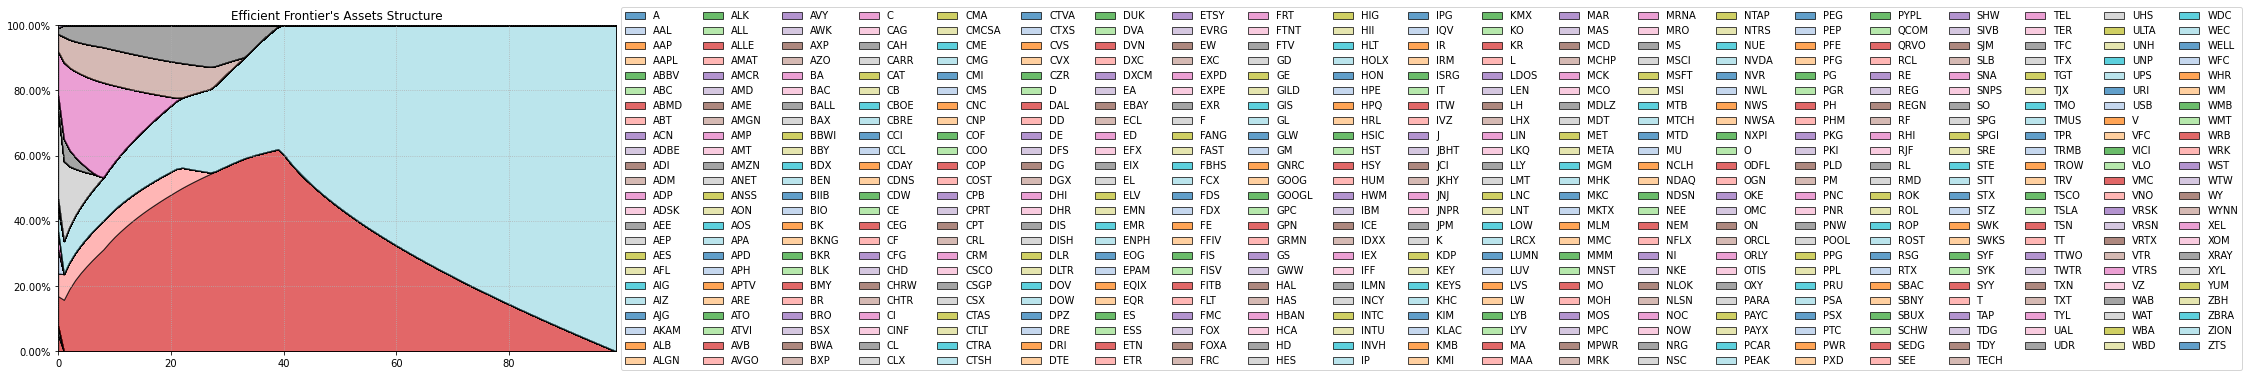

In [14]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot:title={'center':'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot:title={'center':'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot:title={'center':'Portfolio Composition'}>,
       <AxesSubplot:title={'center':'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot:title={'center':'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot:title={'center':'Historical Uncompounded Drawdown'}>],
      dtype=object)

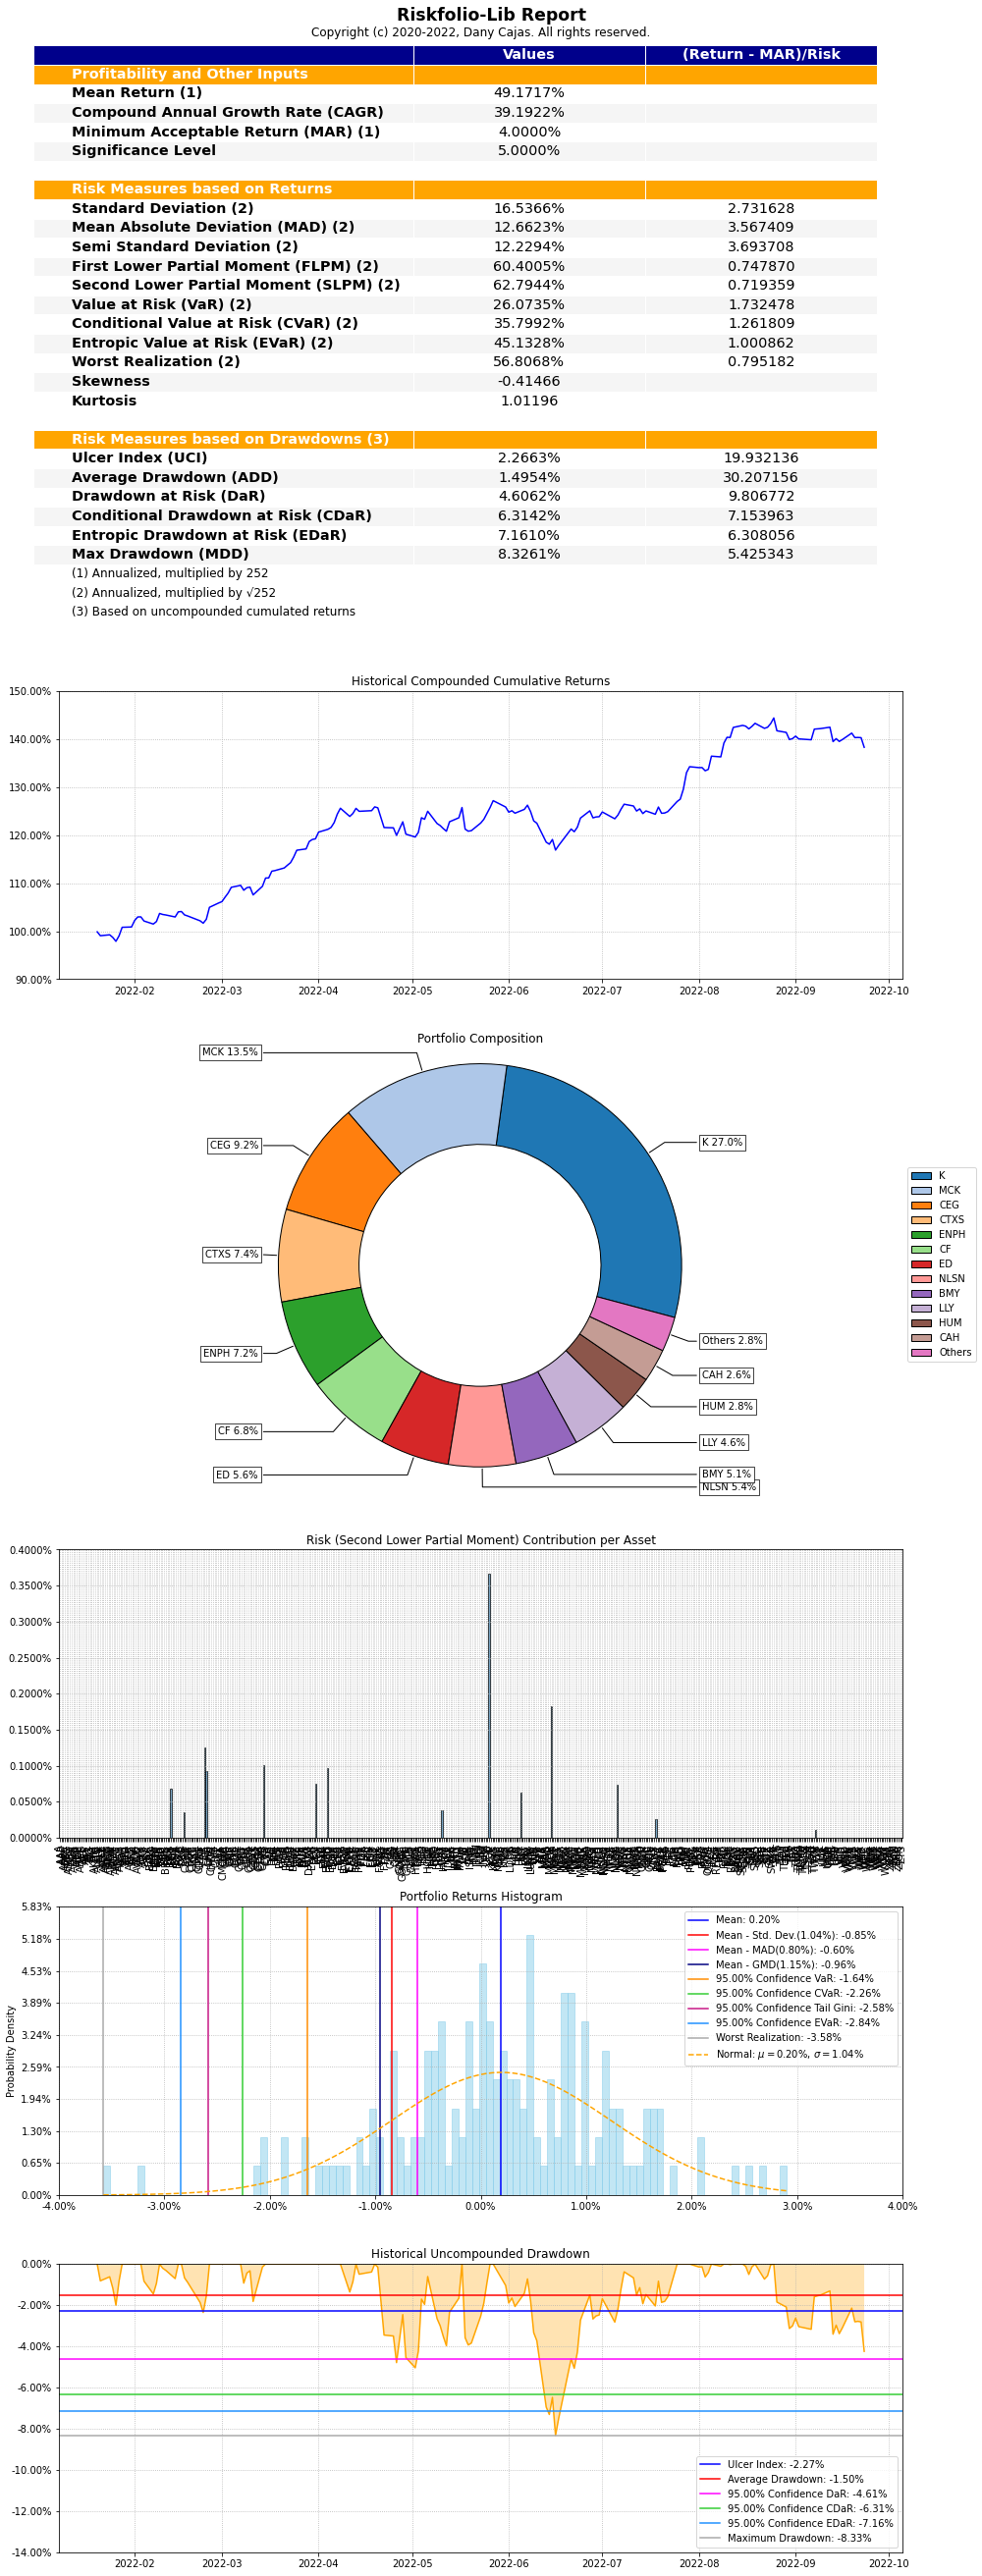

In [15]:
rp.Reports.excel_report(returns, allocations, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='sp500_1y_report')
rp.Reports.jupyter_report(returns, allocations, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.05, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)